<a href="https://colab.research.google.com/github/hanfengsunshine/CHI2020DigitalNotes/blob/master/DISPairwiseComparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install choix

     |████████████████████████████████| 71kB 2.8MB/s 
  Created wheel for choix: filename=choix-0.3.3-cp36-none-any.whl size=18626 sha256=a7ad64d16c18d610188bc57f0821e72497203886567efc160000fb1e818e0007
  Stored in directory: /root/.cache/pip/wheels/ea/02/15/f8e8838b840f508e7e4636684b0046ea8e582647815f916c4c
Successfully built choix


In [0]:
# Import necessary packages
# For data processing
import choix
import csv
import glob
import numpy as np
import pandas as pd
from google.colab import drive
import math
import scipy
from sklearn.metrics import cohen_kappa_score
# For data visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

# Mount to drive 
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Define constants 
# Total number of products
NUM_PRODUCTS = 12
# Total number of attributes 
NUM_ATTRIBUTES = 20
# Number of task attributes 
NUM_TASK_ATTR = 11
# Number of interface attributes
NUM_INTERFACE_ATTR = 6
# Number of context attributes 
NUM_CONTEXT_ATTR = 3
# Directory path 
dirPath = "/content/drive/My Drive/HKUSTHCIInitiative/CrowdSourcing /SurveyResults/ResultsVisualization/"

In [0]:
# Function for getting B-T params
# @params: fileRef
# fileRef: file reference to csv containing win-loss info
# @returns: params
# params: BTL score
def getBTParams(fileRef):
  # List of comparisons
  comps = []
  # Read in list of comparisons
  with open(fileRef) as csvFile:
    readCSV = csv.reader(csvFile, delimiter=",")
    for row in readCSV:
      aIdx = allProducts.index(row[0])
      bIdx = allProducts.index(row[1])
      aWinCount = int(row[2])
      bWinCount = int(row[3])
      comps.extend([(aIdx, bIdx)] * aWinCount)
      comps.extend([(bIdx, aIdx)] * bWinCount)
  # Calculate B-T parameters
  params = choix.mm_pairwise(NUM_PRODUCTS, comps, [1/12]*12)
  probs = choix.probabilities((0,1,2,3,4,5,6,7,8,9,10,11),params)
  return params, probs

# Function for calculating the list of probabilities 
# One product was preferred over another 
def getProbs(attr, attrParams):
  # Get file reference of attribute
  fileRef = glob.glob(dirPath +
                 attr + ".csv")[0]
  # List of probabilities
  actualProbs = []
  predictedProbs = []
  # Read in list of comparisons 
  with open(fileRef) as csvFile:
    readCSV = csv.reader(csvFile, delimiter=",")
    for row in readCSV:
        # Calculate actual probability
        aIdx = allProducts.index(row[0])
        bIdx = allProducts.index(row[1])
        aWinCount = int(row[2])
        bWinCount = int(row[3])
        actualProbs.append(aWinCount / (aWinCount + bWinCount))
        # Get predicted probability 
        predictedProbs.append(choix.probabilities([aIdx,bIdx], attrParams)[0])
  return actualProbs, predictedProbs

# Function for calculating the p-value 
def calcProbPVal(attr,attrParams):
  act, pred = getProbs(attr, attrParams)
  diff = np.absolute(np.subtract(act,pred))
  # z-score calc -> p-val
  diffFromMean = np.mean(diff)
  stdDev = np.std(diff)
  zScore = diffFromMean/stdDev
  pVal = scipy.stats.norm.sf(abs(zScore))
  return pVal

# Function for calculating user agreement
# Using "Maximizing the Guessability of Symbolic Input"
# Read in list of comparisons 
def calcAvgConsensus(attr):
  # Get file reference of attribute
  fileRef = glob.glob(dirPath +
                 attr + ".csv")[0]
  with open(fileRef) as csvFile:
    readCSV = csv.reader(csvFile, delimiter=",")
    agreements = []
    for row in readCSV:
      # Calculate actual probability
      aIdx = allProducts.index(row[0])
      bIdx = allProducts.index(row[1])
      aWinCount = int(row[2])
      bWinCount = int(row[3])
      tot = aWinCount + bWinCount
      agreement = (aWinCount/tot)**2 + (bWinCount/tot)**2
      agreements.append(agreement)
    return np.mean(agreements)
  
# Function for calculating the fleiss kappa score
# From skylander86 - Yanchuan CMU '18: Unsure about citation
def fleiss_kappa(M):
  """
  See `Fleiss' Kappa <https://en.wikipedia.org/wiki/Fleiss%27_kappa>`_.
  :param M: a matrix of shape (:attr:`N`, :attr:`k`) where `N` is the number of subjects and `k` is the number of categories into which assignments are made. `M[i, j]` represent the number of raters who assigned the `i`th subject to the `j`th category.
  :type M: numpy matrix
  """
  N, k = M.shape  # N is # of items, k is # of categories
  n_annotators = float(np.sum(M[0, :]))  # # of annotators

  p = np.sum(M, axis=0) / (N * n_annotators)
  P = (np.sum(M * M, axis=1) - n_annotators) / (n_annotators * (n_annotators - 1))
  Pbar = np.sum(P) / N
  PbarE = np.sum(p * p)

  kappa = (Pbar - PbarE) / (1 - PbarE)

  return kappa

In [0]:
# Products list
allProducts = ["Printed Digital Documents",
            "Paper Crafts & Artworks",
            "Semi-structured Written Forms",
            "Notebooks & Loose Leafs",
            "Books",
            "Sticky Notes",
            "Large-Scale Paper Displays (i.e. Posters)",
            "Paper Cards (i.e. Name Cards)",
            "Maps & Spatial Plans",
            "Calendars",
            "Magazines & Pamphlets",
            "Newspapers"
           ]

In [0]:
# Attributes List
'''
allAttributes = ["Range of Content Input",
              "Information Exploration",
              "Information Organization",
              "Information Findability",
              "Physical Manipulation",
              "Collaboration",
              "Feedback",
              "Personalization",
              "Privacy",
              "Security",
              "Accessibility",
              "Cost",
              "Information Volume",
              "Information Variety",
              "Physical Reconfigurability",
              "Durability",
              "Digitalization",
              "Spatiality",
              "Temporality",
              "Environment"
             ]
'''
allAttributes = ["Range of Content Input",
                 "Information Organization",
              "Information Exploration",
              "Information Findability",
              "Collaboration",
              "Physical Manipulation",
              "Personalization",
              "Feedback",
              "Privacy",
              "Security",
              "Accessibility",
              "Cost",
              "Information Volume",
              "Physical Reconfigurability",
              "Information Variety",
              "Durability",
              "Digitalization",
              "Spatiality",
              "Environment",
              "Temporality",
             ]
for i in range(NUM_ATTRIBUTES):
  print(i,allAttributes[i])

0 Range of Content Input
1 Information Organization
2 Information Exploration
3 Information Findability
4 Collaboration
5 Physical Manipulation
6 Personalization
7 Feedback
8 Privacy
9 Security
10 Accessibility
11 Cost
12 Information Volume
13 Physical Reconfigurability
14 Information Variety
15 Durability
16 Digitalization
17 Spatiality
18 Environment
19 Temporality


In [0]:
# Graph labels 
labels = ["Rng. Inp.",
          "Orgniz.",
          "Explor.",
          "Findbl.",
          "Collab.",
          "Phy. Man.",
          "Prsnal.",
          "Feedbk.",
          "Prvicy.",
          "Secrty.",
          "Access.",
          "Cost",
          "Inf. Vol.",
          "Phy. Rcf.",
          "Inf. Var.",
          "Durabl.",
          "Digtlz.",
          "Sptial.",
          "Envmnt.",
          "Tmpral."
         ]
    
hierarchLabels = [
    ("Rng. Inp.","Task"),
    ("Orgniz.", "Task"),
    ("Explor.", "Task"),
    ("Findbl.", "Task"),
    ("Collab.", "Task"),
    ("Phy. Man.", "Task"),
    ("Prsnal.", "Task"),
    ("Feedbk.", "Task"),
    ("Prvicy.", "Task"),
    ("Secrty.", "Task"),
    ("Access.", "Task"),
    ("Cost", "Interface"),
    ("Inf. Vol.", "Interface"),
    ("Phy. Rcf.", "Interface"),
    ("Inf. Var.", "Interface"),
    ("Durabl.", "Interface"),
    ("Digtlz.", "Interface"),
    ("Sptial.", "Context"),
    ("Envmnt.", "Context"),
    ("Tmpral.", "Context")
]

In [0]:
# Get attributes with data
attributes = []
attrFileRefs = []
for attribute in allAttributes:
  attrFileRef = glob.glob(dirPath +
                 attribute + ".csv")
  if(len(attrFileRef) > 0):
    attributes.append(attribute)
    attrFileRefs.extend(attrFileRef)

In [0]:
def calcPairwiseAgreement():
  # Calculate user agreement
  # Using metric from "Maximizing Guessability of Symbolic Input"
  totAgreement = []
  for i in range(0, len(allAttributes)):
    agreement = calcAvgConsensus(allAttributes[i])
    print(allAttributes[i], "Agreement:", agreement)
    totAgreement.append(agreement)
  print("Average:", np.mean(totAgreement))
  print("Std Dev:", np.std(totAgreement))

In [0]:
def calcPairwiseAgreementFleiss():
  # Calculate user agreement 
  # Using Fleiss Kappa 
  FleissKappaAll = []
  for i in range(NUM_ATTRIBUTES):
    userPrefCount = np.zeros((66,2*66))
    with open(attrFileRefs[i]) as csvFile:
      readCSV = csv.reader(csvFile, delimiter=",")
      rowIdx = 0 
      columnIdx = 0
      for row in readCSV:
        aWinCount = int(row[2])
        bWinCount = int(row[3])
        userPrefCount[rowIdx,columnIdx] = aWinCount
        userPrefCount[rowIdx,columnIdx + 1] = bWinCount
        rowIdx = rowIdx + 1
        columnIdx = columnIdx + 2
    print(userPrefCount)
    FleissKappaAll.append(fleiss_kappa(userPrefCount))
  for i in range(0, len(FleissKappaAll)):
    print(allAttributes[i], "Fleiss Kappa Strength of Agreement:", FleissKappaAll[i])
  print("Average:",np.mean(FleissKappaAll))
  print("Std Dev:", np.std(FleissKappaAll))


In [0]:
# Get BT parameters of each product for each attribute
attrBTParams = []
attrBTScaleParams = []
for i in range(0, len(attrFileRefs)):
  attrBTParam, attrBTScaleParam = getBTParams(attrFileRefs[i])
  attrBTParams.append(attrBTParam)
  attrBTScaleParams.append(attrBTScaleParam)

In [0]:
# Hypothesis testing: BTL is a good model for our data distribution
# Null hypothesis: The difference between the predicted percetange and actual percentage is 0 
# Alternative hypothesis: The difference between the predicted percentage and the actual percentage is > 0
def pValCalcBTL():
  for i in range(len(attributes)):
    pVal = calcProbPVal(attributes[i], attrBTParams[i])
    if(pVal < 0.05):
      print(attributes[i],"z-stat p-val:",pVal)


In [0]:
# Format for pandas data-frame
attributes = np.expand_dims(np.array(attributes), axis=0)
attrBTParams = np.transpose(attrBTParams)
attrBTScaleParams = np.transpose(attrBTScaleParams)

In [0]:
# Build dataframe for BTL scale values
df = pd.DataFrame(data=attrBTScaleParams, columns = attributes[0,:], index=np.arange(0,NUM_PRODUCTS))
df["Product"] = allProducts
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df

,Product,Range of Content Input,Information Organization,Information Exploration,Information Findability,Collaboration,Physical Manipulation,Personalization,Feedback,Privacy,Security,Accessibility,Cost,Information Volume,Physical Reconfigurability,Information Variety,Durability,Digitalization,Spatiality,Environment,Temporality
0,Printed Digital Documents,0.143487,0.158427,0.056019,0.113882,0.049157,0.030926,0.079492,0.107043,0.056315,0.154650,0.023244,0.004638,0.044229,0.063271,0.049493,0.003008,0.247582,0.034821,0.029270,0.055603
1,Paper Crafts & Artworks,0.007429,0.004662,0.015652,0.001142,0.058730,0.164198,0.223001,0.017817,0.123426,0.035637,0.038495,0.042549,0.002595,0.255041,0.004877,0.003478,0.009470,0.089629,0.035685,0.008596
2,Semi-structured Written Forms,0.109172,0.158427,0.031730,0.067123,0.086000,0.029628,0.041718,0.237473,0.025733,0.108698,0.023244,0.009746,0.031383,0.072430,0.014474,0.002863,0.152638,0.037644,0.037094,0.117608
3,Notebooks & Loose Leafs,0.176467,0.118906,0.018047,0.010462,0.062986,0.116458,0.071010,0.120042,0.099236,0.154650,0.075813,0.014986,0.031383,0.026979,0.007542,0.014307,0.031793,0.060681,0.030475,0.009130
4,Books,0.101198,0.039751,0.131497,0.308876,0.050960,0.111757,0.018317,0.049353,0.174937,0.154650,0.041621,0.344993,0.264425,0.005515,0.066511,0.907879,0.070104,0.040631,0.060573,0.033546
5,Sticky Notes,0.034556,0.101593,0.016425,0.021781,0.136504,0.116458,0.112256,0.082523,0.114667,0.029067,0.106275,0.002933,0.004234,0.172233,0.004877,0.000239,0.037445,0.075046,0.026969,0.028258
6,Large-Scale Paper Displays (i.e. Posters),0.101198,0.071834,0.273026,0.051836,0.126829,0.010801,0.116771,0.059382,0.069681,0.031582,0.206025,0.212375,0.059373,0.023480,0.117350,0.015023,0.035961,0.145251,0.198992,0.049009
7,Paper Cards (i.e. Name Cards),0.055614,0.097720,0.033065,0.031884,0.080256,0.027158,0.137175,0.082523,0.045249,0.100838,0.091334,0.026068,0.008246,0.013688,0.026318,0.004596,0.133872,0.077749,0.081930,0.045063
8,Maps & Spatial Plans,0.045871,0.036561,0.065931,0.079809,0.131557,0.069221,0.025429,0.049353,0.074767,0.075148,0.046699,0.118196,0.076184,0.172233,0.138413,0.006018,0.053414,0.211506,0.060573,0.018885
9,Calendars,0.072313,0.123752,0.033065,0.033369,0.095441,0.028373,0.092512,0.092170,0.056315,0.048423,0.139928,0.057216,0.013072,0.011665,0.016860,0.017460,0.139783,0.069922,0.054148,0.317233


In [0]:
# Build dataframe from expectation median values
dfMedian = pd.read_csv(dirPath + "ExpectationsMedian.csv", names = attributes[0,:])
dfMedian["Product"] = allProducts
cols = dfMedian.columns.tolist()
cols = cols[-1:] + cols[:-1]
dfMedian = dfMedian[cols]

In [0]:
# Build dataframe from expectation IQR values
dfIQR = pd.read_csv(dirPath + "ExpectationsIQR.csv", names = attributes[0,:])
dfIQR["Product"] = allProducts
cols = dfIQR.columns.tolist()
cols = cols[-1:] + cols[:-1]
dfIQR = dfIQR[cols]

In [0]:
# Get BTL scale vals, expectation medians, expectation IQRs of attrIdx
asterProducts = ["Printed\nDigital\nDocuments",
            "Paper Crafts\n& Artworks",
            "Semi-\nstructured\nWritten\nForms",
            "Notebooks &\nLoose Leafs",
            "Books",
            "Sticky Notes",
            "Large-Scale\nPaper\nDisplays\n(i.e. Posters)",
            "Paper Cards\n(i.e. Name\nCards)",
            "Spatial Plans\n(i.e. Maps)",
            "Calendars",
            "Magazines &\nPamphlets",
            "Newspapers"
           ]

prodIdx = 10
prodBTLVals = df.loc[prodIdx,allAttributes].values.flatten().tolist()
orig = prodBTLVals
scaleBTLVals = []
for i in range(len(prodBTLVals)):
  scaleVal = prodBTLVals[i]*100
  if scaleVal > 1:
    scaleBTLVals.append(math.log10(scaleVal) + 1.375)
  else:
    scaleBTLVals.append(scaleVal)
prodBTLVals = scaleBTLVals

prodExpectMeds = dfMedian.loc[prodIdx,allAttributes].values.flatten().tolist()
prodExpectIQR = dfIQR.loc[prodIdx, allAttributes].values.flatten().tolist()
prodExpectValids = [IQR <= 2 for IQR in prodExpectIQR]

'''
prodExpectMeds = np.random.randint(1,6,20).astype(np.float)
prodExpectIQR = np.random.randint(1,4,20).astype(np.float)
prodExpectValids = [IQR <= 2 for IQR in prodExpectIQR]
prodBTLVals = np.multiply(np.random.random(20), 0.1)
scaleBTLVals = []
for i in range(len(prodBTLVals)):
  scaleVal = prodBTLVals[i]*100
  if scaleVal > 1:
    scaleBTLVals.append(math.log10(scaleVal) + 1)
  else:
    scaleBTLVals.append(scaleVal)
prodBTLVals = scaleBTLVals
'''

for i in range(0,20):
  print(hierarchLabels[i][0], orig[i], prodExpectMeds[i])


Rng. Inp. 0.09041646990684521 3.0
Orgniz. 0.05480063732690898 4.0
Explor. 0.22936727192302056 5.0
Findbl. 0.09513052604504725 4.5
Collab. 0.077532404034006 3.5
Phy. Man. 0.08772382712760521 4.5
Prsnal. 0.05457228173806377 1.0
Feedbk. 0.028379975189136816 2.5
Prvicy. 0.06726603688686542 2.0
Secrty. 0.04842258408822785 1.5
Access. 0.1193451959290137 3.0
Cost 0.1479079779440588 1.0
Inf. Vol. 0.24738085383836972 4.5
Phy. Rcf. 0.028243882357167818 3.0
Inf. Var. 0.39820230630134723 5.0
Durabl. 0.01937324225555565 3.5
Digtlz. 0.03452505153951241 4.0
Sptial. 0.08962886588045947 3.0
Envmnt. 0.2720773523410267 3.0
Tmpral. 0.08548345554172465 4.0


In [38]:
# Aster Plot 
# Define limits 
innerStart = 1
innerStartLog = 0.375
innerRange = 3 + innerStartLog
outerStartOffset = 0.75
outerStart = innerStart + innerRange + outerStartOffset
outerRange = 0.5
# Define color scheme 
taskColors = ["#fee5d9", 
              "#fcbba1", 
              "#fc9272", 
              "#fb6a4a", 
              "#de2d26", 
              "#a50f15"]
interfaceColors= ["#edf8e9",
                  "#c7e9c0",
                  "#a1d99b",
                  "#74c476",
                  "#31a354",
                  "#006d2c"]
contextColors = ["#eff3ff",
                 "#c6dbef",
                 "#9ecae1",
                 "#6baed6",
                 "#3182bd",
                 "#08519c"]

# Calculate inner thetas, widths, heights, colors, textures
inBottom = [innerStart] * NUM_ATTRIBUTES
inWidth = [360/NUM_ATTRIBUTES] * NUM_ATTRIBUTES
inTheta = np.arange(0,360,360/NUM_ATTRIBUTES)
inHeight = []
for BTLVal in prodBTLVals: 
  if BTLVal < 0.075: 
    inHeight.append(0.075)
  else:
    inHeight.append(BTLVal)
inCol = []
for i in range(0,NUM_TASK_ATTR):
  inCol.append(taskColors[int(math.ceil(prodExpectMeds[i]))])
for i in range(NUM_TASK_ATTR, NUM_TASK_ATTR + NUM_INTERFACE_ATTR):
  inCol.append(interfaceColors[int(math.ceil(prodExpectMeds[i]))])
for i in range(NUM_TASK_ATTR + NUM_INTERFACE_ATTR,
               NUM_TASK_ATTR + NUM_INTERFACE_ATTR + NUM_CONTEXT_ATTR):
  inCol.append(contextColors[int(math.ceil(prodExpectMeds[i]))])
# Separate out high IQR values 
inBottomL = []
inWidthL = []
inThetaL = []
inHeightL = []
inColL = []
inBottomH = []
inWidthH = []
inThetaH = []
inHeightH = []
inColH = []
for i, valid in enumerate(prodExpectValids):
  if(valid):
    inBottomL.append(inBottom[i])
    inWidthL.append(inWidth[i])
    inThetaL.append(inTheta[i])
    inHeightL.append(inHeight[i])
    inColL.append(inCol[i])
  else:
    inBottomH.append(inBottom[i])
    inWidthH.append(inWidth[i])
    inThetaH.append(inTheta[i])
    inHeightH.append(inHeight[i])
    inColH.append(inCol[i])

# Figure set-up
plt.figure(figsize=(15,15))
ax = plt.subplot(projection='polar')
ax.set_ylim(0, outerStart + outerRange)
ax.axis('off')

# Plot inner background 
inBBottom = inBottom
inBWidth = inWidth 
inBTheta = inTheta
inBHeight = [innerRange] * NUM_ATTRIBUTES
inBCol = []
inBCol.extend([taskColors[0]] * NUM_TASK_ATTR)
inBCol.extend([interfaceColors[0]] * NUM_INTERFACE_ATTR)
inBCol.extend([contextColors[0]] * NUM_CONTEXT_ATTR)
ax.bar(
    [math.radians(theta) for theta in inBTheta],
    height=inBHeight,
    width=[math.radians(width) for width in inBWidth],
    bottom=inBBottom,
    color=inBCol,
    align='edge',
    edgecolor="white",
    linewidth=2.5
)
inBBottom = [innerStart + innerRange] * NUM_ATTRIBUTES
inBWidth = inWidth 
inBTheta = inTheta
inBHeight = [outerStartOffset] * NUM_ATTRIBUTES
inBCol = []
inBCol.extend([taskColors[0]] * NUM_TASK_ATTR)
inBCol.extend([interfaceColors[0]] * NUM_INTERFACE_ATTR)
inBCol.extend([contextColors[0]] * NUM_CONTEXT_ATTR)
ax.bar(
    [math.radians(theta) for theta in inBTheta],
    height=inBHeight,
    width=[math.radians(width) for width in inBWidth],
    bottom=inBBottom,
    color=inBCol,
    align='edge',
    edgecolor="white",
    linewidth=2.5
)

ax.bar(
    [math.radians(theta) for theta in inThetaL],
    height=inHeightL,
    width=[math.radians(width) for width in inWidthL],
    bottom=inBottomL,
    color=inColL,
    align='edge',
    edgecolor="white",
    linewidth=2.5
)
ax.bar(
    [math.radians(theta) for theta in inThetaH],
    height=inHeightH,
    width=[math.radians(width) for width in inWidthH],
    bottom=inBottomH,
    color=inColH,
    align='edge',
    hatch="-",
    edgecolor="white",
    linewidth=2.5
)

# Calculate outer theta, width, bottom, height, color
outTheta = [inTheta[0],
            inTheta[NUM_TASK_ATTR],
            inTheta[NUM_TASK_ATTR + NUM_INTERFACE_ATTR]
           ]
outWidth = [(360/NUM_ATTRIBUTES)*NUM_TASK_ATTR,
            (360/NUM_ATTRIBUTES)*NUM_INTERFACE_ATTR,
            (360/NUM_ATTRIBUTES)*NUM_CONTEXT_ATTR] 
outBottom = [outerStart] * 3 
outHeight = [outerRange] * 3 
outCol = [taskColors[5],
          interfaceColors[5],
          contextColors[5]]

# Plot outer 
ax.bar(
    [math.radians(theta) for theta in outTheta],
    height=outHeight,
    width=[math.radians(width) for width in outWidth],
    bottom=outBottom,
    color=outCol,
    align='edge',
    edgecolor="white",
    linewidth=2.5
)

# Label 
# Inner categories 
for i in range(0,NUM_ATTRIBUTES):
  if(i >= 10):
    plt.text(math.radians(inTheta[i] + inWidth[i]/2), 
             innerStart + innerRange + (outerStartOffset*0.75), 
             hierarchLabels[i][0],
             horizontalalignment="center",
             verticalalignment="bottom",
             rotation=inTheta[i] + inWidth[i]/2 + 90,
             rotation_mode="anchor",
             fontsize=18,
             fontweight="bold"
            )
  else:
    plt.text(math.radians(inTheta[i] + inWidth[i]/2), 
             innerStart + innerRange + (outerStartOffset*0.75), 
             hierarchLabels[i][0],
             horizontalalignment="center",
             verticalalignment="top",
             rotation=inTheta[i] + inWidth[i]/2 + -90,
             rotation_mode="anchor",
             fontsize=18,
             fontweight="bold"
            )
# Outer categories 
plt.text(math.radians(outTheta[0] + outWidth[0]/2), 
             outerStart + (outerRange*0.5), 
             "Task",
             horizontalalignment="center",
             verticalalignment="center",
             rotation=outTheta[0] + outWidth[0]/2 - 90,
             rotation_mode="anchor",
             fontsize=24,
             fontweight="bold",
             color="white"
            )
plt.text(math.radians(outTheta[1] + outWidth[1]/2), 
             outerStart + (outerRange*0.5), 
             "Interface",
             horizontalalignment="center",
             verticalalignment="center",
             rotation=outTheta[1] + outWidth[1]/2 + 90,
             rotation_mode="anchor",
             fontsize=24,
             fontweight="bold",
             color="white"
            )
plt.text(math.radians(outTheta[2] + outWidth[2]/2), 
             outerStart + (outerRange*0.5), 
             "Context",
             horizontalalignment="center",
             verticalalignment="center",
             rotation=outTheta[2] + outWidth[2]/2 + 90,
             rotation_mode="anchor",
             fontsize=24,
             fontweight="bold",
             color="white"
            )

# Label axis 
plt.text(0,
         innerStart + 0.5,
         ".005",
         horizontalalignment="left",
         verticalalignment="top",
         rotation_mode="anchor",
         rotation=-2.5,
         fontsize=14,
         fontweight="bold",
         color="black"
        )
ax.bar(
    0,
    height=0,
    width=math.radians(360),
    bottom=innerStart + 0.5,
    edgecolor="white",
    linewidth=2.5
)
# End of linear scale 
plt.text(0,
         innerStart + 1,
         ".01",
         horizontalalignment="left",
         verticalalignment="bottom",
         rotation_mode="anchor",
         rotation=-95,
         fontsize=14,
         fontweight="bold",
         color="black"
        )
ax.bar(
    0,
    height=innerStartLog,
    width=math.radians(360),
    bottom=innerStart + 1,
    color="white"
)
plt.text(0,
         innerStart + innerStartLog + 1,
         ".01",
         horizontalalignment="left",
         verticalalignment="bottom",
         rotation_mode="anchor",
         rotation=-95,
         fontsize=14,
         fontweight="bold",
         color="black"
        )


plt.text(0,
         innerStart + 1 + innerStartLog + 0.5,
         ".03",
         horizontalalignment="left",
         verticalalignment="bottom",
         rotation_mode="anchor",
         rotation=-95,
         fontsize=14,
         fontweight="bold",
         color="black"
        )
ax.bar(
    0,
    height=0,
    width=math.radians(360),
    bottom=innerStart + 1 + innerStartLog + 0.5,
    edgecolor="white",
    linewidth=2.5
)
plt.text(0,
         innerStart + 2 + innerStartLog,
         "0.1",
         horizontalalignment="left",
         verticalalignment="bottom",
         rotation_mode="anchor",
         rotation=-92.5,
         fontsize=14,
         fontweight="bold",
         color="black"
        )
ax.bar(
    0,
    height=0,
    width=math.radians(360),
    bottom=innerStart + 2 + innerStartLog,
    align='edge',
    edgecolor="white",
    linewidth=2.5
)
plt.text(0,
         innerStart + 2 + innerStartLog + 0.5,
         "0.3",
         horizontalalignment="left",
         verticalalignment="bottom",
         rotation_mode="anchor",
         rotation=-92.5,
         fontsize=14,
         fontweight="bold",
         color="black"
        )
ax.bar(
    0,
    height=0,
    width=math.radians(360),
    bottom=innerStart + 2 + innerStartLog + 0.5,
    edgecolor="white",
    linewidth=2.5
)
plt.text(0,
         innerStart + 3 + innerStartLog,
         "1.0",
         horizontalalignment="left",
         verticalalignment="bottom",
         rotation_mode="anchor",
         rotation=-92.5,
         fontsize=14,
         fontweight="bold",
         color="black"
        )

# Product 
plt.text(0,0,
         asterProducts[prodIdx],
         horizontalalignment="center",
         verticalalignment="center",
         fontsize=18,
         fontweight="bold",
        )
'''
plt.text(0,0,
         "Packaging",
         horizontalalignment="center",
         verticalalignment="center",
         fontsize=18,
         fontweight="bold",
        )
'''
plt.savefig(asterProducts[prodIdx]+".svg")

NameError: ignored

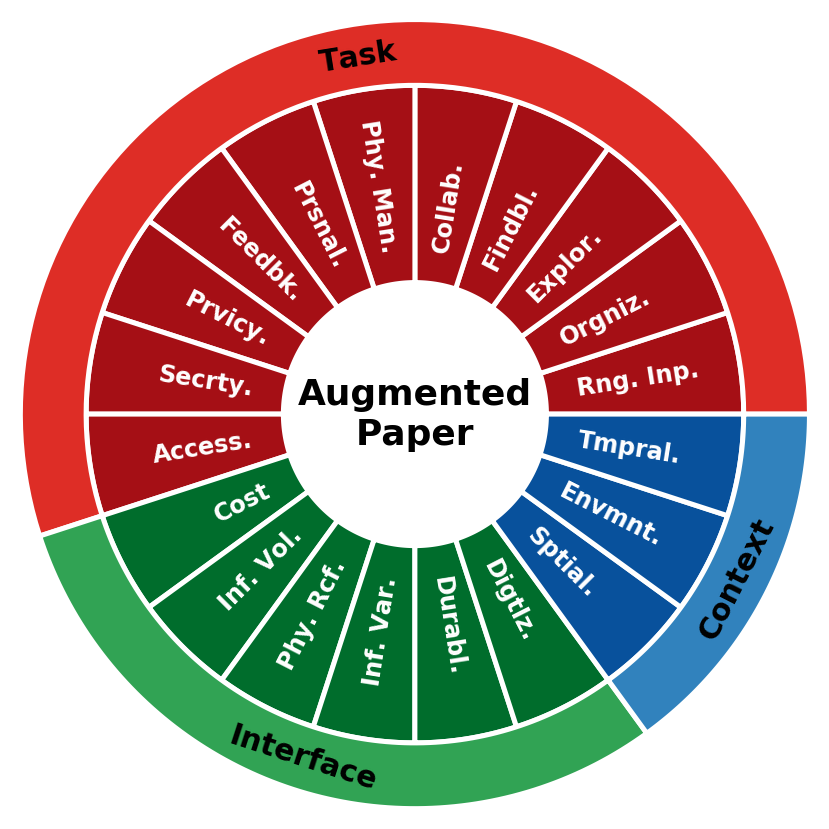

In [39]:
# Radial Plot of Attributes

# Define limits 
innerStart = 1
innerRange = 1.5
outerStart = innerStart + innerRange 
outerRange = 0.5

# Define color scheme 
taskColors = ["#fee5d9", 
              "#fcbba1", 
              "#fc9272", 
              "#fb6a4a", 
              "#de2d26", 
              "#a50f15"]
interfaceColors= ["#edf8e9",
                  "#c7e9c0",
                  "#a1d99b",
                  "#74c476",
                  "#31a354",
                  "#006d2c"]
contextColors = ["#eff3ff",
                 "#c6dbef",
                 "#9ecae1",
                 "#6baed6",
                 "#3182bd",
                 "#08519c"]

# Calculate inner thetas, widths, heights, colors, textures
inBottom = [innerStart] * NUM_ATTRIBUTES
inWidth = [360/NUM_ATTRIBUTES] * NUM_ATTRIBUTES
inTheta = np.arange(0,360,360/NUM_ATTRIBUTES)
inHeight = [innerRange] * NUM_ATTRIBUTES
inCol = []
for i in range(0,NUM_TASK_ATTR):
  inCol.append(taskColors[5])
for i in range(NUM_TASK_ATTR, NUM_TASK_ATTR + NUM_INTERFACE_ATTR):
  inCol.append(interfaceColors[5])
for i in range(NUM_TASK_ATTR + NUM_INTERFACE_ATTR,
               NUM_TASK_ATTR + NUM_INTERFACE_ATTR + NUM_CONTEXT_ATTR):
  inCol.append(contextColors[5])

# Figure set-up
plt.figure(figsize=(15,15))
ax = plt.subplot(projection='polar')
ax.axis('off')


# Plot inner
ax.bar(
    [math.radians(theta) for theta in inTheta],
    height=inHeight,
    width=[math.radians(width) for width in inWidth],
    bottom=inBottom,
    color=inCol,
    align='edge',
    edgecolor="white",
    linewidth=5
)

# Label inner
for i in range(0,NUM_ATTRIBUTES):
  if(i >= 5 and i <= 14):
    plt.text(math.radians(inTheta[i] + inWidth[i]/2), 
             innerStart + 0.25, 
             hierarchLabels[i][0],
             horizontalalignment="right",
             verticalalignment="center",
             rotation=inTheta[i] + inWidth[i]/2 + 180,
             rotation_mode="anchor",
             fontsize=24,
             fontweight="bold",
             color="white"
            )
  else:
    plt.text(math.radians(inTheta[i] + inWidth[i]/2), 
             innerStart + 0.25, 
             hierarchLabels[i][0],
             horizontalalignment="left",
             verticalalignment="center",
             rotation=inTheta[i] + inWidth[i]/2,
             rotation_mode="anchor",
             fontsize=24,
             fontweight="bold",
             color="white"
            )
    
# Calculate outer thetas, widths, heights, colors, textures
outTheta = [inTheta[0],
            inTheta[NUM_TASK_ATTR],
            inTheta[NUM_TASK_ATTR + NUM_INTERFACE_ATTR]
           ]
outWidth = [(360/NUM_ATTRIBUTES)*NUM_TASK_ATTR,
            (360/NUM_ATTRIBUTES)*NUM_INTERFACE_ATTR,
            (360/NUM_ATTRIBUTES)*NUM_CONTEXT_ATTR] 
outBottom = [outerStart] * 3 
outHeight = [outerRange] * 3 
outCol = [taskColors[4],
          interfaceColors[4],
          contextColors[4]]
# Plot outer 
ax.bar(
    [math.radians(theta) for theta in outTheta],
    height=outHeight,
    width=[math.radians(width) for width in outWidth],
    bottom=outBottom,
    color=outCol,
    align='edge',
    edgecolor="white",
    linewidth=5
)
# Label outer
plt.text(math.radians(outTheta[0] + outWidth[0]/2), 
             outerStart + (outerRange*0.5), 
             "Task",
             horizontalalignment="center",
             verticalalignment="center",
             rotation=outTheta[0] + outWidth[0]/2 - 90,
             rotation_mode="anchor",
             fontsize=30,
             fontweight="bold",
             color="black"
            )
plt.text(math.radians(outTheta[1] + outWidth[1]/2), 
             outerStart + (outerRange*0.5), 
             "Interface",
             horizontalalignment="center",
             verticalalignment="center",
             rotation=outTheta[1] + outWidth[1]/2 + 90,
             rotation_mode="anchor",
             fontsize=30,
             fontweight="bold",
             color="black"
            )
plt.text(math.radians(outTheta[2] + outWidth[2]/2), 
             outerStart + (outerRange*0.5), 
             "Context",
             horizontalalignment="center",
             verticalalignment="center",
             rotation=outTheta[2] + outWidth[2]/2 + 90,
             rotation_mode="anchor",
             fontsize=30,
             fontweight="bold",
             color="black"
            )

plt.text(0,0,
         "Augmented\nPaper",
         horizontalalignment="center",
         verticalalignment="center",
         fontsize=36,
         fontweight="bold",
        )

plt.savefig("dimensions.svg")


<Figure size 10800x7200 with 0 Axes>

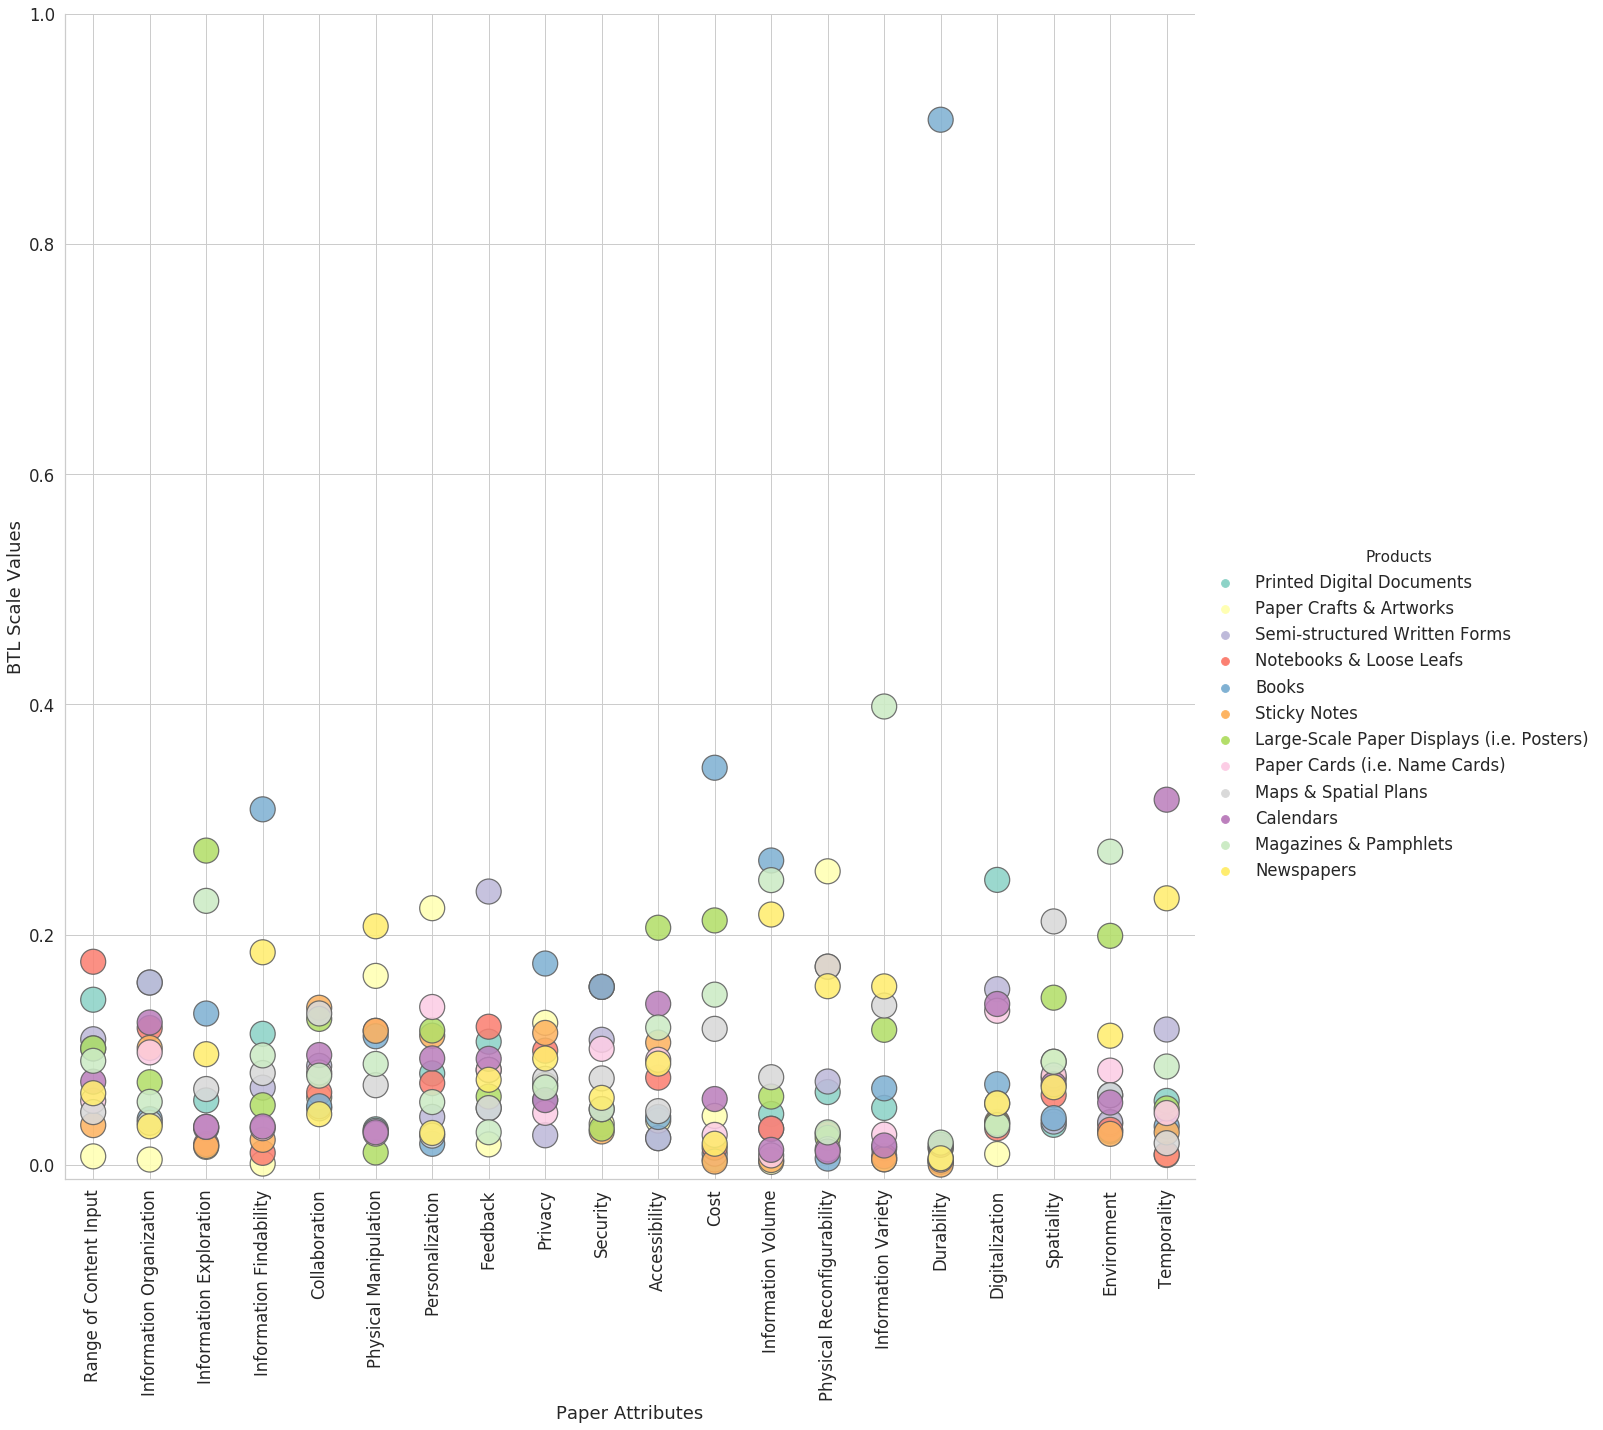

In [0]:
def drawParallelPlot():
  # Convert data to long-form for seaborn 
  cols = df.columns.tolist()
  productCol = df[cols[0]]
  attribCols = cols[1:]
  # long-form data frame
  dfLong = pd.DataFrame({"Products":{}, "Attribute":{}, "Score":{}})
  for i in range(0, NUM_PRODUCTS):
    for j in range(0, NUM_ATTRIBUTES):
      dfLong = dfLong.append({"Products": productCol[i], "Attribute": attribCols[j], "Score":df[attribCols[j]][i]}, ignore_index=True)
      
  # Parallel Plot
  plt.figure(figsize=(150,100))
  sns.set(font_scale=1.5)
  sns.set_style('whitegrid')
  color_list = plt.cm.Set3(np.linspace(0, 1, 12))
  sns.set_palette(color_list)
  g = sns.catplot(x="Attribute", 
                   y="Score", 
                   hue="Products",
                   data=dfLong, 
                   s=25,
                   edgecolor='gray',
                   linewidth=1.25,
                   jitter=False,
                   height=17.5, 
                   aspect=1,
                   alpha=0.875
                  )
  #ax.text(<product idx>, <BTL scale score>, <text>)
  g.set_xlabels("Paper Attributes")
  g.set_ylabels("BTL Scale Values")
  g.set_xticklabels(rotation=90)
  axes = g.axes
  axes[0,0].set_ylim(-0.0125,1.0)
  plt.grid(b=True,which="major")
drawParallelPlot()

In [0]:
def drawRadar():
  # Radar Graphs 
  color_list = plt.cm.Set3(np.linspace(0, 1, 12))
  subset = np.arange(0,12)
  fig, axs = plt.subplots(6,2, figsize=(20,50))
  sns.set()
  sns.set_style("whitegrid")
  for i in range(len(subset)):
    radVals = df.loc[subset[i],allAttributes].values.flatten().tolist()
    radVals += radVals[:1]
    radVals = np.divide(radVals, np.sum(radVals))

    ax = plt.subplot(6,2,i+1, polar=True)
    N = len(labels)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    plt.rcParams.update({'font.size': 30, 'font.weight':'normal'})
    plt.xticks(angles[:-1], labels, color='black', size=12.5, wrap=True)
    ax.set_rlabel_position(90)
    plt.yticks([0.0,0.1, 0.2, 0.3],color='grey')
    ax.plot(angles, radVals, "-o", color=color_list[subset[i]],
            linewidth=1.5, mec='gray',
            markeredgewidth=1.5,
            markersize=2.5, alpha=0.875)
    ax.set_ylim(-0.1,0.4)
    ax.fill(angles,radVals,'b', color=color_list[subset[i]], alpha=0.5)
    ax.set_title(allProducts[subset[i]],fontsize=20)

  plt.tight_layout()
#drawRadar()

In [0]:
def drawLitDistRadar():
  # Radar Graphs for Literature Distribution 
  # Read in csv
  litDist = []
  litDistRef = dirPath + "LitDist.csv"
  # Read in list of distributions 
  with open(litDistRef) as csvFile:
    readCSV = csv.reader(csvFile, delimiter=",")
    for row in readCSV:
      entry = [] 
      for val in row:
        entry.append(float(val))
      litDist.append(entry)

  subset = np.arange(0,12)
  fig, axs = plt.subplots(6,2, figsize=(20,50))
  sns.set()
  sns.set_style("whitegrid")
  
  for i in range(len(subset)):
    radVals = df.loc[subset[i],allAttributes].values.flatten().tolist()
    radVals += radVals[:1]
    litRadVals = litDist[i]
    litRadVals += litRadVals[:1]
    ax = plt.subplot(6,2,i+1, polar=True)
    N = len(labels)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    plt.rcParams.update({'font.size': 30, 'font.weight':'normal'})
    plt.xticks(angles[:-1], labels, color='black', size=12.5, wrap=True)
    ax.set_rlabel_position(90)
    plt.yticks([0.0,0.1, 0.2, 0.3, 0.4],color='grey')
    ax.plot(angles, litRadVals, "-o", color="black",
            linewidth=1.5, mec='gray',
            markeredgewidth=1.5,
            markersize=2.5, alpha=0.75)
    ax.plot(angles, radVals, "-o", color=color_list[subset[i]],
            linewidth=1.5, mec='gray',
            markeredgewidth=1.5,
            markersize=2.5, alpha=0.875)
    ax.set_ylim(-0.05,0.4)
    ax.fill(angles,radVals,'b', color=color_list[subset[i]], alpha=0.5)
    ax.set_title(allProducts[subset[i]],fontsize=20)

  plt.tight_layout()

In [0]:
def drawHeatmap():
  # Heatmaps
  # Long-form dataframe containing preference probabilities 
  dfPrefProb = pd.DataFrame({"Row Product":{}, 
                           "Column Product":{},
                           "Attribute":{},
                           "Preference Probability":{}
                          })

  # Function for calculating probability that one product will be 
  # preferred over another in a comparison 
  def getCompareProb(attr, attrParams):
    compareProb = np.zeros((NUM_PRODUCTS,NUM_PRODUCTS))
    for i in range(0, NUM_PRODUCTS):
      for j in range(0, NUM_PRODUCTS):
        if i != j:
          compareProb[i,j] = choix.probabilities([i,j],attrParams)[0]
    return compareProb

  # Plot 
  fig, axs = plt.subplots(10,2,figsize=(50,250))
  for k in range(len(allAttributes)):
    compareProb = getCompareProb(allAttributes[k], attrBTParams[:,k])
    ax = plt.subplot(10,2,k+1)
    im = ax.imshow(compareProb, cmap="Blues")

    # Format x and y axes
    ax.set_xticks(np.arange(NUM_PRODUCTS))
    ax.set_yticks(np.arange(NUM_PRODUCTS))
    ax.set_xticklabels(allProducts)
    ax.set_yticklabels(allProducts)
    ax.tick_params(top=True, bottom=False,
                  labeltop=True, labelbottom=False)
    plt.setp(ax.get_xticklabels(),rotation=-30, ha="right",
            rotation_mode="anchor")

    # Title
    ax.set_title(allAttributes[k],fontsize=20,y=-0.1)

    # Turn spine off and create white grid 
    ax.grid(False)
    for edge, spine in ax.spines.items():
      spine.set_visible(False)
    ax.set_xticks(np.arange(compareProb.shape[1]+1)-0.5,minor=True)
    ax.set_yticks(np.arange(compareProb.shape[0]+1)-0.5,minor=True)
    ax.grid(which="minor",color="w",linestyle="-",linewidth=3)
    ax.tick_params(which="minor",bottom=False,left=False)

    # Create colorbar
    cbar = ax.figure.colorbar(im)
    cbar.ax.set_ylabel("Preference Probability", rotation=-90, va="bottom")

    # Loop over data dimensions and create text annotation
    for i in range(NUM_PRODUCTS):
        for j in range(NUM_PRODUCTS):
          if compareProb[i,j] > 0.5:
            text = ax.text(j, i, '%.2f' % compareProb[i, j],
                           ha="center", va="center", color="w")
          else:
            text = ax.text(j, i, '%.2f' % compareProb[i, j],
                           ha="center", va="center", color="k")

  #attrBTParams[:,0].shape